# Estudio COVID-19
Objetivo de este notebook:
- Analizar contagios por rango etario
- Comparar fallecimientos con datos del min de salud y de covid stats ar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path_Covid19Casos = '/home/franco/Documentos/Python/Clones/republica-liberal/COVID-19_Ar/datasetsCovid/Covid19Casos.csv'
df_covid_casos = pd.read_csv(path_Covid19Casos)

In [3]:
df_covid_casos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1594538 entries, 0 to 1594537
Data columns (total 25 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   id_evento_caso                    1594538 non-null  int64  
 1   sexo                              1594538 non-null  object 
 2   edad                              1592805 non-null  float64
 3   edad_años_meses                   1594538 non-null  object 
 4   residencia_pais_nombre            1594538 non-null  object 
 5   residencia_provincia_nombre       1594538 non-null  object 
 6   residencia_departamento_nombre    1594538 non-null  object 
 7   carga_provincia_nombre            1594538 non-null  object 
 8   fecha_inicio_sintomas             896957 non-null   object 
 9   fecha_apertura                    1594537 non-null  object 
 10  sepi_apertura                     1594538 non-null  int64  
 11  fecha_internacion                 148

In [4]:
df_covid_casos.head(5)

,id_evento_caso,sexo,edad,edad_años_meses,residencia_pais_nombre,residencia_provincia_nombre,residencia_departamento_nombre,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,...,fecha_fallecimiento,asistencia_respiratoria_mecanica,carga_provincia_id,origen_financiamiento,clasificacion,clasificacion_resumen,residencia_provincia_id,fecha_diagnostico,residencia_departamento_id,ultima_actualizacion
0,1000000,M,53.0,Años,Argentina,CABA,SIN ESPECIFICAR,Buenos Aires,NaN,2020-06-01,...,NaN,NO,6,Privado,Caso Descartado,Descartado,2,2020-06-09,0,2020-09-15
1,1000002,M,21.0,Años,Argentina,Buenos Aires,La Matanza,Buenos Aires,NaN,2020-06-01,...,NaN,NO,6,Público,Caso Descartado,Descartado,6,2020-06-01,427,2020-09-15
2,1000003,F,40.0,Años,Argentina,Córdoba,Capital,Córdoba,2020-05-24,2020-06-01,...,NaN,NO,14,Privado,Caso Descartado,Descartado,14,2020-06-01,14,2020-09-15
3,1000005,F,58.0,Años,Argentina,Mendoza,Las Heras,Mendoza,NaN,2020-06-01,...,NaN,NO,50,Público,Caso Descartado,Descartado,50,2020-06-01,49,2020-09-15
4,1000006,M,28.0,Años,Argentina,Buenos Aires,Malvinas Argentinas,Buenos Aires,2020-05-30,2020-06-01,...,NaN,NO,6,Público,Caso sospechoso - Con muestra sin resultado,Sospechoso,6,NaN,515,2020-09-15


## Analisis de contagios por rango etario

In [5]:
df_covid_casos.columns

Index(['id_evento_caso', 'sexo', 'edad', 'edad_años_meses',
       'residencia_pais_nombre', 'residencia_provincia_nombre',
       'residencia_departamento_nombre', 'carga_provincia_nombre',
       'fecha_inicio_sintomas', 'fecha_apertura', 'sepi_apertura',
       'fecha_internacion', 'cuidado_intensivo', 'fecha_cui_intensivo',
       'fallecido', 'fecha_fallecimiento', 'asistencia_respiratoria_mecanica',
       'carga_provincia_id', 'origen_financiamiento', 'clasificacion',
       'clasificacion_resumen', 'residencia_provincia_id', 'fecha_diagnostico',
       'residencia_departamento_id', 'ultima_actualizacion'],
      dtype='object')

In [6]:
df_covid_casos['residencia_provincia_nombre'].unique()

array(['CABA', 'Buenos Aires', 'Córdoba', 'Mendoza', 'Formosa',
       'Santa Fe', 'San Luis', 'Entre Ríos', 'Tucumán', 'Chaco',
       'Corrientes', 'Río Negro', 'La Pampa', 'Santa Cruz',
       'Santiago del Estero', 'Neuquén', 'SIN ESPECIFICAR', 'San Juan',
       'Chubut', 'Catamarca', 'Tierra del Fuego', 'Misiones', 'Jujuy',
       'La Rioja', 'Salta'], dtype=object)

In [7]:
columns_contagio_edades = [
    'sexo',
    'edad',
    'residencia_provincia_nombre',
    'residencia_departamento_nombre', 
    'fallecido', 
    'asistencia_respiratoria_mecanica',
    'clasificacion_resumen']

In [8]:
df_covid_casos_reducido = df_covid_casos[columns_contagio_edades]
df_covid_casos_reducido

,sexo,edad,residencia_provincia_nombre,residencia_departamento_nombre,fallecido,asistencia_respiratoria_mecanica,clasificacion_resumen
0,M,53.0,CABA,SIN ESPECIFICAR,NO,NO,Descartado
1,M,21.0,Buenos Aires,La Matanza,NO,NO,Descartado
2,F,40.0,Córdoba,Capital,NO,NO,Descartado
3,F,58.0,Mendoza,Las Heras,NO,NO,Descartado
4,M,28.0,Buenos Aires,Malvinas Argentinas,NO,NO,Sospechoso
...,...,...,...,...,...,...,...
1594533,M,39.0,Tierra del Fuego,Río Grande,NO,NO,Descartado
1594534,M,33.0,Formosa,Pilcomayo,NO,NO,Confirmado
1594535,M,42.0,CABA,SIN ESPECIFICAR,NO,NO,Descartado
1594536,F,30.0,CABA,SIN ESPECIFICAR,NO,NO,Descartado


In [9]:
df_covid_casos_reducido['clasificacion_resumen'].value_counts()

Descartado        879589
Confirmado        577330
Sospechoso        137573
Sin Clasificar        46
Name: clasificacion_resumen, dtype: int64

In [10]:
df_confirmados = df_covid_casos_reducido.loc[df_covid_casos_reducido['clasificacion_resumen'] == 'Confirmado']
df_confirmados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 577330 entries, 5 to 1594534
Data columns (total 7 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   sexo                              577330 non-null  object 
 1   edad                              576989 non-null  float64
 2   residencia_provincia_nombre       577330 non-null  object 
 3   residencia_departamento_nombre    577330 non-null  object 
 4   fallecido                         577330 non-null  object 
 5   asistencia_respiratoria_mecanica  577330 non-null  object 
 6   clasificacion_resumen             577330 non-null  object 
dtypes: float64(1), object(6)
memory usage: 35.2+ MB


<AxesSubplot:ylabel='Frequency'>

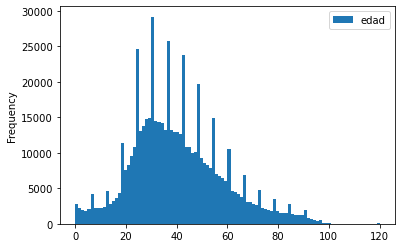

In [11]:
df_confirmados.plot(kind='hist', bins=100)

In [12]:
df_confirmados[df_confirmados.edad.isnull()].shape

(341, 7)

## Estudio de medidas de tendencia central de las edades.

### Contagidos

In [13]:
# moda

moda = np.nan # defino la variable moda

valores, conteo_valores = np.unique(df_confirmados['edad'], return_counts=True) # Retorna array con valores unicos del array que le pase.

pos = np.argmax(conteo_valores) # Del conteo de valores retorname el valor máximo. Este será la posición
moda = valores[pos] # Con la posicion anterior encuentro el valor que mas se repite.
moda

29.0

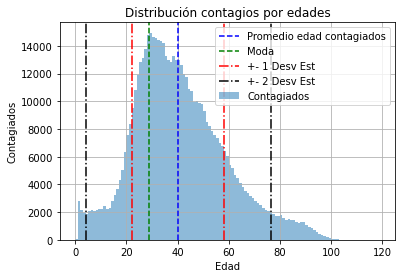

In [14]:
df_confirmados['edad'].hist(bins = range(0,120,1),label = 'Contagiados', alpha = 0.5)

# Media y moda
plt.axvline(np.mean(df_confirmados['edad']), c='b', linestyle='--', label='Promedio edad contagiados')
plt.axvline(moda, c='g', linestyle='--', label='Moda')

# Una desviacion estandar
plt.axvline(np.mean(df_confirmados['edad']) + np.std(df_confirmados['edad']), c='r', linestyle='-.', label='+- 1 Desv Est')
plt.axvline(np.mean(df_confirmados['edad']) - np.std(df_confirmados['edad']), c='r', linestyle='-.')

# 2 desviacion estandar
plt.axvline(np.mean(df_confirmados['edad']) + 2*np.std(df_confirmados['edad']), c='k', linestyle='-.', label='+- 2 Desv Est')
plt.axvline(np.mean(df_confirmados['edad']) - 2*np.std(df_confirmados['edad']), c='k', linestyle='-.')

plt.title('Distribución contagios por edades')
plt.xlabel('Edad')
plt.ylabel('Contagiados')
plt.legend()
plt.show()

La media de edades de los contagiados es de 40 años, pero los que mas se han contagiados han sido las personas de entre 29 y 31 años. La moda es de 29 años.

A 1 desviacion estandar, a la derecha e izquierda, tenemos el 68.2% de los datos aproximadamente.

A 2 desviaciones estandar se encuentra el 95.4% de los datos aproximadamente. 

### Fallecidos

In [15]:
df_fallecido = df_confirmados[df_confirmados['fallecido'] == 'SI']

In [16]:
# moda

moda = np.nan # defino la variable moda

valores, conteo_valores = np.unique(df_fallecido['edad'], return_counts=True) # Retorna array con valores unicos del array que le pase.

pos = np.argmax(conteo_valores) # Del conteo de valores retorname el valor máximo. Este será la posición
moda = valores[pos] # Con la posicion anterior encuentro el valor que mas se repite.

moda, np.mean(df_fallecido['edad'])

(78.0, 72.26951970963113)

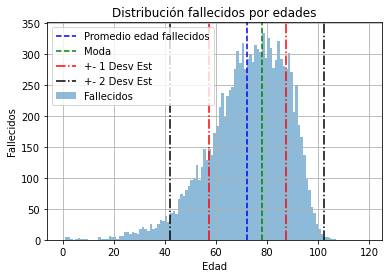

In [17]:
df_fallecido['edad'].hist(bins = range(0,120,1),label = 'Fallecidos', alpha = 0.5)

# Media y moda
plt.axvline(np.mean(df_fallecido['edad']), c='b', linestyle='--', label='Promedio edad fallecidos')
plt.axvline(moda, c='g', linestyle='--', label='Moda')

# Una desviacion estandar
plt.axvline(np.mean(df_fallecido['edad']) + np.std(df_fallecido['edad']), c='r', linestyle='-.', label='+- 1 Desv Est')
plt.axvline(np.mean(df_fallecido['edad']) - np.std(df_fallecido['edad']), c='r', linestyle='-.')

# 2 desviacion estandar
plt.axvline(np.mean(df_fallecido['edad']) + 2*np.std(df_fallecido['edad']), c='k', linestyle='-.', label='+- 2 Desv Est')
plt.axvline(np.mean(df_fallecido['edad']) - 2*np.std(df_fallecido['edad']), c='k', linestyle='-.')

plt.title('Distribución fallecidos por edades')
plt.xlabel('Edad')
plt.ylabel('Fallecidos')
plt.legend()
plt.show()

La media de edades de los fallecidos es de 72 años, pero los que mas se han contagiados y fallecidos han sido las personas de entre 75 y 81 años. La moda es de 79 años.

A 1 desviacion estandar, a la derecha e izquierda, tenemos el 68.2% de los datos aproximadamente.

A 2 desviaciones estandar se encuentra el 95.4% de los datos aproximadamente.

### Comparacion Contagiados vs Fallecidos

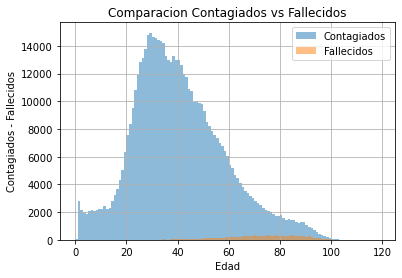

In [18]:
df_confirmados['edad'].hist(bins = range(0,120,1),label = 'Contagiados', alpha = 0.5)
df_fallecido['edad'].hist(bins = range(0,120,1),label = 'Fallecidos', alpha = 0.5)

plt.title('Comparacion Contagiados vs Fallecidos')
plt.xlabel('Edad')
plt.ylabel('Contagiados - Fallecidos')
plt.legend()
plt.show()

In [19]:
df_confirmados['edad'].max()

120.0

In [20]:
df_confirmados['edad'].min()

0.0

In [21]:
df_confirmados['sexo'].value_counts()

M     292868
F     282593
NR      1869
Name: sexo, dtype: int64

### Contagios por generos

In [22]:
serie_edad_hombres = df_confirmados['edad'][df_confirmados['sexo'] == 'M']
serie_edad_mujeres = df_confirmados['edad'][df_confirmados['sexo'] == 'F']

serie_edad_hombres_fallecidos = df_fallecido['edad'][df_fallecido['sexo'] == 'M']
serie_edad_mujeres_fallecidos = df_fallecido['edad'][df_fallecido['sexo'] == 'F']

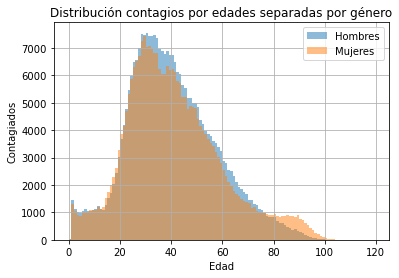

In [23]:
serie_edad_hombres.hist(bins = range(0,120,1),label = 'Hombres', alpha = 0.5)
serie_edad_mujeres.hist(bins = range(0,120,1),label = 'Mujeres', alpha = 0.5)


plt.title('Distribución contagios por edades separadas por género')
plt.xlabel('Edad')
plt.ylabel('Contagiados')
plt.legend()
plt.show()

In [24]:
# Porcentaje de contagios en hombres y mujeres

total_contagiados = df_confirmados['edad'].value_counts().sum()
df_confirmados['sexo'].value_counts() / total_contagiados * 100


M     50.757987
F     48.977190
NR     0.323923
Name: sexo, dtype: float64

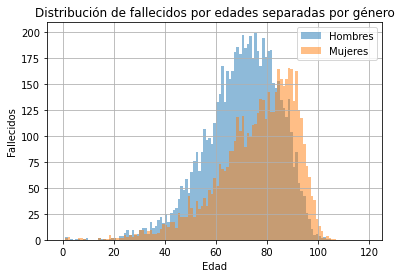

In [25]:
serie_edad_hombres_fallecidos.hist(bins = range(0,120,1),label = 'Hombres', alpha = 0.5)
serie_edad_mujeres_fallecidos.hist(bins = range(0,120,1),label = 'Mujeres', alpha = 0.5)


plt.title('Distribución de fallecidos por edades separadas por género')
plt.xlabel('Edad')
plt.ylabel('Fallecidos')
plt.legend()
plt.show()

In [26]:
# Porcentaje de fallecidos en hombres y mujeres

total_fallecidos = df_fallecido['edad'].value_counts().sum()
df_fallecido['sexo'].value_counts() / total_fallecidos * 100


M     56.664134
F     42.609943
NR     0.768127
Name: sexo, dtype: float64

In [27]:
np.mean(df_fallecido['edad']) + np.std(df_fallecido['edad'])

87.30297449182287

In [28]:
np.mean(df_fallecido['edad']) - np.std(df_fallecido['edad'])

57.23606492743939